In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import math
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from ipywidgets import interact, IntSlider
from IPython.display import display

from lmfit import Model
# import lmfit as lm

In [2]:
"""Defining the Hamiltonian XY model"""

def Hamiltonian2D(J, L):
    Hamiltonian2D = 0.
    n = np.shape(L)[0]
    for x in range (np.shape(L)[0]):
        for y in range (np.shape(L)[0]):
            Hamiltonian2D -= J * ((np.cos(L[x, y] - L[x, (y+1)%n])) + (np.cos(L[x, y] - L[x, (y-1)%n])) 
                                  + (np.cos(L[x, y] - L[(x+1)%n, y])) + (np.cos(L[x, y] - L[(x-1)%n, y])))
    
    
    return Hamiltonian2D/2


In [3]:
"""Defining the artifical Hamiltonian XY model"""

def Hamiltonian2D_art(J, L, P, beta):
    n = np.shape(L)[0]
    Hamiltonian2D_art = sum(sum(P**2))/2 + beta*Hamiltonian2D(J, L)
    return Hamiltonian2D_art

# print(Hamiltonian2D_art(1, L, 1, 1 ))

In [4]:
"""Defining the equations of motion"""

def P_dot_i_2D(J, L):
    n = np.shape(L)[0]
    P_dot_i_2D = np.zeros((n,n))

    for x in range (np.shape(L)[0]):
        for y in range (np.shape(L)[0]):
            P_dot_i_2D[x,y] -= J * ((np.sin(L[x, y] - L[x, (y+1)%n])) + (np.sin(L[x, y] - L[x, (y-1)%n])) 
                                    + (np.sin(L[x, y] - L[(x+1)%n, y])) + (np.sin(L[x, y] - L[(x-1)%n, y])))
    return P_dot_i_2D*beta*J


In [5]:
"""Leapfrog integrator"""

def leapfrog_2D(N_md, p_0,J, L): 
    epsilon = 1/N_md
    p = np.copy(p_0)
    L_new = np.copy(L)
    L_new += p*epsilon/2

    for i in range(N_md-1):
        p += P_dot_i_2D(J, L_new)*epsilon
        L_new += p*epsilon

    
    p +=  P_dot_i_2D(J, L_new)*epsilon
    L_new -= p*epsilon/2
    L_new = abs(L_new%(2*np.pi))
    return p, L_new



In [6]:
"""Now we code the HMC algorithm and get a markove chain (List containing spins) out of it"""

def markov_chain(L_i,N_cfg,N_md,beta,J):
    
    M_arr=[]
    E_arr=[]
    E2_arr=[]
    M2_arr=[]
    spin_list = []
    # L_i_save = L_i

    # bin_length
    count=0
    for k in range(n_therm):
          
        p_hmc = np.random.normal(size=(N,N))
        new = leapfrog_2D(N_md, p_hmc,J, L_i) # Integrating leapfrog algorithm
        prob = np.exp(Hamiltonian2D_art(J,L_i,p_hmc,beta)-Hamiltonian2D_art(J,new[1],new[0],beta))
        if prob > np.random.uniform(0,1):   # Accept/reject
            L_i=new[1] 
                
        
    # L_i = L_i_save
    for i in range(N_cfg):
        m = 0.0
        E = 0.0
        m2=0.
        e2=0.
        for k in range(bin_length):
            
            p_hmc = np.random.normal(size=(N,N))
            new = leapfrog_2D(N_md, p_hmc,J, L_i) # Integrating leapfrog algorithm
            E_new=Hamiltonian2D_art(J,L_i,p_hmc,beta)
            E_old=Hamiltonian2D_art(J,new[1],new[0],beta)
            prob = np.exp(E_old-E_new)
#  Given probability distribution function defined above
            if prob > np.random.uniform(0,1):
                # print("selected")
                Mag=np.sqrt(np.sum(np.cos(new[1]))**2+np.sum(np.sin(new[1]))**2)/N**2
                En=Hamiltonian2D(J,new[1])/N**2
                count+=1
                m2+=Mag**2
                e2+=En**2
                m += Mag
                E += En

        
                L_i = new[1]
                spin_list.append(L_i)

            else:
                Mag=np.sqrt(np.sum(np.cos(L_i))**2+np.sum(np.sin(L_i))**2)/N**2
                En=Hamiltonian2D(J,L_i)/N**2
                m2+=Mag**2
                e2+=En**2
                m += Mag
                E += En
            
        M_arr.append(m / bin_length)
        E_arr.append(E / bin_length)
        M2_arr.append(m2 / bin_length)
        E2_arr.append(e2 / bin_length)

                
    print("Acceptance rate", count / (N_cfg*bin_length))
    return M_arr,E_arr, M2_arr, E2_arr, spin_list



In [7]:
"""To virtually observe the behaviour of spin lattice over some specific 
computation steps the following function can be used"""


def plotting_spins_range(vectors_list, range_initial, range_final, steps, N):

    temp_vectors_list = vectors_list[range_initial:range_final:steps]

    @interact(index=IntSlider(min=0, max=len(temp_vectors_list)-1, step=1, value=0))
    def display_graph(index):
        matrix = temp_vectors_list[index]

        fig, ax = plt.subplots()
        x, y = np.meshgrid(np.arange(N), np.arange(N))
        x_components = np.cos(matrix)
        y_components = np.sin(matrix)
        ax.quiver(x, y, x_components, y_components, angles='xy', scale_units='xy', scale=1)
        ax.set_xlim([-1, N])
        ax.set_ylim([-1, N])
        ax.set_aspect('equal')

        plt.show()

    # Display the interact widget
    display(display_graph)




In [8]:
"""The following function calculates the energy, magnatization, susceptibility 
and heat of lattice for each given point of temprature as 1/Temperature"""


def Analysis_func(N,n_therm,bin_length,N_cfg,N_md,J,T_arr,beta_arr,L_i):


    E_means = []
    mag_means = []

    m_std = []
    E_std = []

    sus = []
    sus_std = []

    heat = []
    heat_std = []

    spinlist = []

    for beta in beta_arr:
        mag_,E_,M2_arr, E2_arr, spinlist = markov_chain(L_i,N_cfg,N_md,beta,J)


        k_ = np.mean(np.array(mag_))
        en_ = np.mean(np.array(E_))
        E_means.append(en_)
        mag_means.append(k_)

        m_std.append(np.std(mag_))
        E_std.append(np.std(E_))

        sus.append((np.mean( M2_arr) - np.square(np.mean(mag_)))*beta*N**2)
        sus_std.append(np.std( M2_arr - np.square(mag_)*beta*N**2))

        heat.append((np.mean(E2_arr) - np.square(np.mean(np.array(E_))))*beta**2*N**2)
        heat_std.append(np.std((E2_arr - np.array(E_)**2)*beta**2*N**2))


    return E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std 

In [9]:
"FITTING STARTS HERE"


def Lorentzian(x, amp1, cen1, wid1):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2))

gmodel = Model(Lorentzian)



"""To understand the behavious of the lattice over the given temperature and 
to find the proper fitting to it we define the following function"""

def Fittings(T_arr, N, E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std):
    
    plt.scatter(T_arr[::-1], E_means,label="Energy")
    plt.errorbar(T_arr[::-1], E_means, yerr=E_std, ls = "")
    plt.grid()
    plt.legend()
    plt.xlabel("Temperature (units)")
    plt.ylabel("Energy <E>")
    plt.title(f"Dependence of Energy on Temperature for N = {N}")
    plt.savefig(f"energy_{N}.png")
    plt.show()

    plt.scatter(T_arr[::-1],mag_means,label="Magnetization")
    plt.errorbar(T_arr[::-1], mag_means, yerr=m_std,ls = "")
    plt.grid()
    plt.legend()
    plt.xlabel("Temperature (units)")
    plt.ylabel("Magnetization <m>")
    plt.title(f"Dependence of Magnetization on Temperature for N = {N}")
    plt.savefig(f"mag_{N}.png")
    plt.show()

    params = gmodel.make_params(amp1=0.25, cen1=0.6, wid1=0.15)
    result = gmodel.fit(sus, params, x=T_arr[::-1])
    print(result.fit_report())

    beta_arr_cont= np.linspace(0,2.2,100)
    fitted_func= Lorentzian(beta_arr_cont, result.params.valuesdict()['amp1'],
                             result.params.valuesdict()['cen1'],result.params.valuesdict()['wid1'])
    



    plt.scatter(T_arr[::-1],sus,label="Susceptibility")
    plt.errorbar(T_arr[::-1], sus, yerr=np.array(sus_std)/N**2,ls = "")
    plt.plot(beta_arr_cont, fitted_func, '.-', label='Fit Function')
    plt.grid()
    plt.legend()
    plt.xlabel("Temperature (units)")
    plt.ylabel("Susceptibility")
    plt.title(f"Dependence of Susceptibility on Temperature for N = {N}")
    plt.savefig(f"sus_{N}.png")
    plt.show()

    T_arr_new= T_arr[::-1]
    popt, cov= curve_fit(Lorentzian, T_arr_new[T_arr_new>0.6], np.array(heat)[T_arr_new>0.6])
    print(popt)

    beta_arr_cont= np.linspace(0,2.2,100)
    fitted_func_heat= Lorentzian(beta_arr_cont, popt[0],
                             popt[1],popt[2])
    
    peak_value_heat = np.max(fitted_func_heat)

    plt.scatter(T_arr_new[T_arr_new>0.25],np.array(heat)[T_arr_new>0.25],label="Specific Heat")
    plt.errorbar(T_arr[::-1], heat, yerr=np.array(heat_std)/N**2,ls = "")
    plt.plot(beta_arr_cont, fitted_func_heat, '.-', label='Fit Function')
    plt.ylim(0,peak_value_heat)
    plt.grid()
    plt.legend()
    plt.xlabel("Temperature (units)")
    plt.ylabel("Specific Heat")
    plt.title(f"Dependence of Specific Heat on Temperature for N = {N}")
    plt.savefig(f"sp_heat_{N}.png")
    plt.show()


In [10]:
"""To study the TRENDS (change in behaviour of lattice with the variations in lattice sizes) 
the following function is used"""

def Trends(N_list,E_means_new,E_std_new,mag_means_new,m_std_new,sus_new,sus_std_new,heat_new,heat_std_new):
    
    legend_labels = [f"N={n}" for n in N_list]
    
    # Plotting graph for Dependence of Energy on Temperature for various N
    for i, Energy_list in enumerate(E_means_new):
        plt.scatter(T_arr[::-1], Energy_list, marker='o', label=legend_labels[i])
        plt.errorbar(T_arr[::-1], Energy_list, yerr=E_std_new[i], ls = "")

    plt.legend(loc='upper right')
    plt.xlabel("Temperature (units)")
    plt.ylabel("Energy <E>")
    plt.title("Dependence of Energy on Temperature for various N")
    plt.savefig("energy_trend.png")
    plt.grid(True)
    plt.show()

    
    
    # Plotting graph for Dependence of Magnetization on Temperature for various N
    for i, Magnetization_list in enumerate(mag_means_new):
        plt.scatter(T_arr[::-1], Magnetization_list, marker='o', label=legend_labels[i])
        plt.errorbar(T_arr[::-1], Magnetization_list, yerr=m_std_new[i], ls = "")

    plt.legend(loc='upper right')
    plt.xlabel("Temperature (units)")
    plt.ylabel("Magnetization <m>")
    plt.title("Dependence of Magnetization on Temperature for various N")
    plt.savefig("mag_trend.png")
    plt.grid(True)
    plt.show()
    
    
    
    # Plotting graph for Dependence of Susceptibility on Temperature for various N
    for i, Susceptibility_list in enumerate(sus_new):
        plt.scatter(T_arr[::-1], Susceptibility_list, marker='o', label=legend_labels[i])
        plt.errorbar(T_arr[::-1], Susceptibility_list, yerr=sus_std_new[i], ls = "")

    plt.legend(loc='upper right')
    plt.xlabel("Temperature (units)")
    plt.ylabel("Susceptibility")
    plt.title("Dependence of Susceptibility on Temperature for various N")
    plt.savefig("sus_trend.png")
    plt.grid(True)
    plt.show()
    
    
    
    # Plotting graph for Dependence of Specific Heat on Temperature for various N
    for i, Specific_Heat_list in enumerate(heat_new):
        plt.scatter(T_arr[::-1], Specific_Heat_list, marker='o', label=legend_labels[i])
        plt.errorbar(T_arr[::-1], Specific_Heat_list, yerr=heat_std_new[i], ls = "")

    plt.legend(loc='upper right')
    # plt.ylim(0,2)
    plt.xlabel("Temperature (units)")
    plt.ylabel("Specific Heat")
    plt.title("Dependence of Specific Heat on Temperature for various N")
    plt.savefig("sp_heat_trend.png")
    plt.grid(True)
    plt.show()
    





[[3.45702326 1.56649069 3.84245553 0.79366551 0.43515131]
 [5.99798217 5.31083664 3.35845288 2.96565799 0.62676481]
 [2.88867249 0.95397316 2.73586813 3.12792328 4.7303256 ]
 [1.4920106  3.26933553 4.42239577 3.98546174 5.04697948]
 [1.84120192 5.19814162 1.86172258 1.57938438 1.2022669 ]]
2


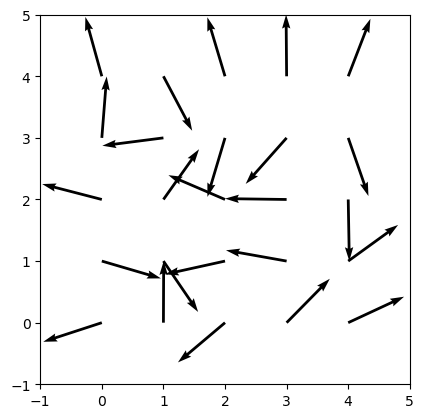

In [11]:
"""Just to visualize a Spin lattice"""
N = 5
L =  np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)]) # ask
p_0 = np.random.normal(size=(N,N))
J = 1
beta = 1.0

print(L)

fig, ax = plt.subplots()
x, y = np.meshgrid(np.arange(5), np.arange(5))
x_components = np.cos(L)
y_components = np.sin(L)
ax.quiver(x, y, x_components, y_components, angles='xy', scale_units='xy', scale=1)
ax.set_xlim([-1, 5])
ax.set_ylim([-1, 5])
ax.set_aspect('equal')


# Defining some variables

print(np.ndim(L))

ini= 14.54665654804953
final= 14.594129513387855


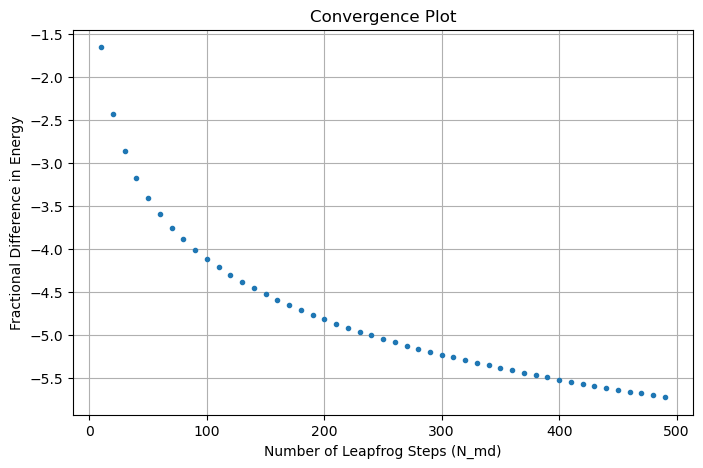

In [12]:
"""To see the convergence of leapfrog integrator"""


diff = []
range_1 =[i for i in range(10,500,10)]
p_0 = np.random.normal(size=(N,N))
for N_md in range_1:
   
    arr = leapfrog_2D(N_md, p_0, J,L)
    p_f = arr[0]          # We need final values of p_f and phi_f to calculate H_f
    Lat_ev = arr[1]
    H_f = Hamiltonian2D_art(J, Lat_ev, p_f, beta)
    H_0 = Hamiltonian2D_art(J, L, p_0, beta)
# dimension of L is 2 and p_0 
# The following is the quantity we want on y-axis
    diff.append(abs((H_f-H_0)/H_0)) 
    
# print(p_0)
# print(L)
# print(phi_f)

print("ini=",H_0)
print("final=",H_f)


plt.figure(figsize=(8,5))
plt.xlabel('Number of Leapfrog Steps (N_md)')
plt.ylabel('Fractional Difference in Energy')
plt.title('Convergence Plot')
plt.grid()
plt.plot(range_1, np.log(diff),'.')
# plt.yscale("log")
plt.show()
# plt.savefig("leap.pgf")
# plt.savefig("leap.png")

Acceptance rate 0.9137
M_avg = 0.7908169737816595, E_avg = -1.3890188321600414


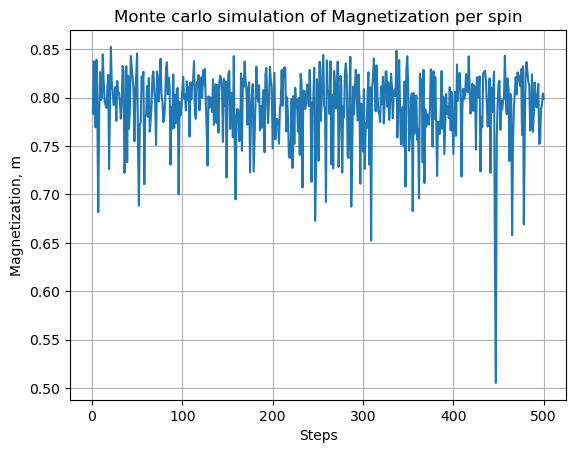

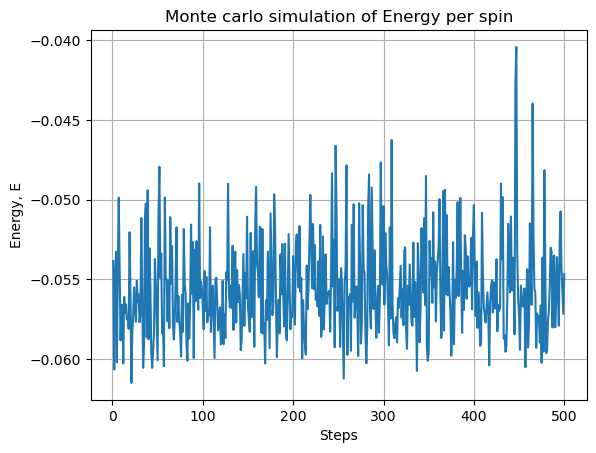

In [13]:
"""To see the general trend of Monte Carlo simulation for spin lattice"""

n_therm = 1000
bin_length = 20
L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
N_cfg = 500
N_md = 30
J = 1.0
beta = 1.0
M_arr,E_arr, M2_arr, E2_arr, spinlist = markov_chain(L_i,N_cfg,N_md,beta,J)
M_avg = np.mean(M_arr)
E_avg = np.mean(E_arr)
print(f"M_avg = {M_avg}, E_avg = {E_avg}")


plt.plot(np.arange(1,N_cfg+1,1),M_arr)
plt.grid()
plt.xlabel("Steps")
plt.ylabel("Magnetization, m")
plt.title("Monte carlo simulation of Magnetization per spin")
plt.show()
# plt.savefig("mcmc_mag.png")
# plt.savefig("mcmc_mag.pgf")

plt.plot(np.arange(1,N_cfg+1,1),np.array(E_arr)/N**2)
plt.grid()
plt.xlabel("Steps")
plt.ylabel("Energy, E")
plt.title("Monte carlo simulation of Energy per spin")
plt.show()
# plt.savefig("mcmc_energy.png")
# plt.savefig("mcmc_mag.pgf")

In [14]:
"""To graphically observe the behaviour of lattice on big scale, hence variations in spin lattice over given computation steps"""
N = 50
n_therm = 10
N_cfg = 5

L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
bin_length = 20
N_md = 30
J = 1.0
beta = 1.0

M_arr,E_arr, M2_arr, E2_arr, spinlist = markov_chain(L_i,N_cfg,N_md,beta,J)
M_avg = np.mean(M_arr)
E_avg = np.mean(E_arr)
print(f"M_avg = {M_avg}, E_avg = {E_avg}")

Acceptance rate 0.94
M_avg = 0.10132673058022859, E_avg = -1.2121181826816851


In [15]:
"""Now we plot the selected range of graphs from the data calculated above for observation"""
# plotting_spins_range(vectors_list, range_initial, range_final, steps, N)
plotting_spins_range(spinlist, 0, 50, 1, N)

print(f"\n ***Use slider to scroll between slides*** \n \n Average magnatization = {M_avg} \n Average energy = {E_avg}")

interactive(children=(IntSlider(value=0, description='index', max=49), Output()), _dom_classes=('widget-intera…

<function __main__.plotting_spins_range.<locals>.display_graph(index)>


 ***Use slider to scroll between slides*** 
 
 Average magnatization = 0.10132673058022859 
 Average energy = -1.2121181826816851


# Fitting

Acceptance rate 0.33619333333333334
Acceptance rate 0.3778666666666667
Acceptance rate 0.43212666666666666
Acceptance rate 0.5112933333333334
Acceptance rate 0.6324
Acceptance rate 0.83718
Acceptance rate 0.7864266666666667
Acceptance rate 0.29984
Acceptance rate 0.01696
Acceptance rate 0.0003066666666666667
Acceptance rate 0.00017333333333333334
Fitting for N = 5


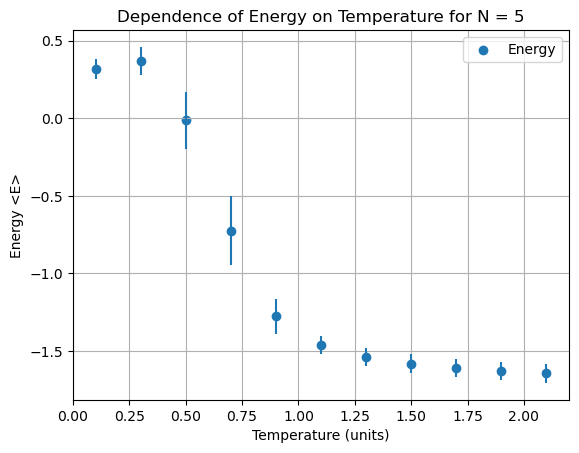

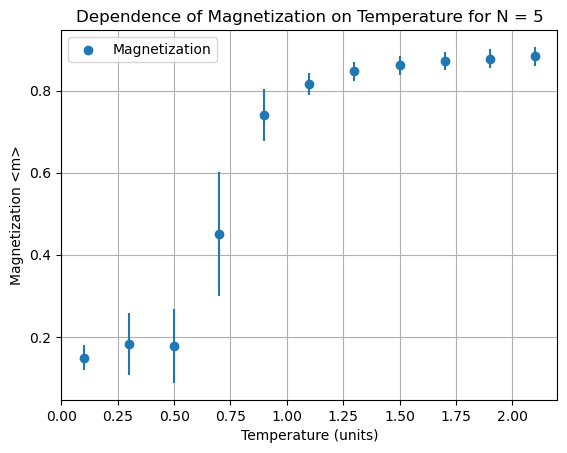

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 11
    # variables        = 3
    chi-square         = 0.11407525
    reduced chi-square = 0.01425941
    Akaike info crit   = -44.2567148
    Bayesian info crit = -43.0630290
    R-squared          = 0.90127969
[[Variables]]
    amp1:  1.14577553 +/- 0.13363866 (11.66%) (init = 0.25)
    cen1:  0.67528784 +/- 0.02810058 (4.16%) (init = 0.6)
    wid1:  0.17023428 +/- 0.02874907 (16.89%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.635
    C(amp1, cen1) = -0.352
    C(cen1, wid1) = 0.331


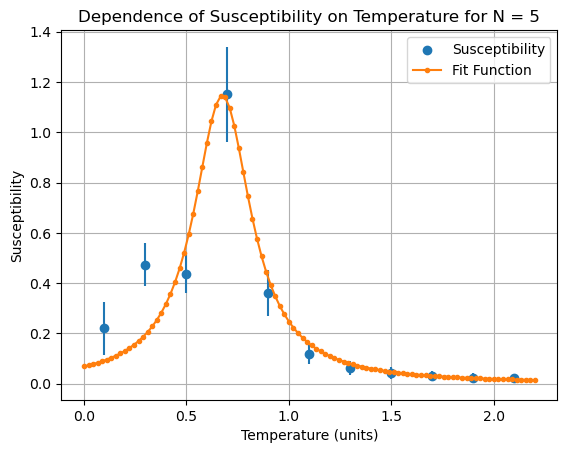

[3.45452916 0.70143795 0.17832429]


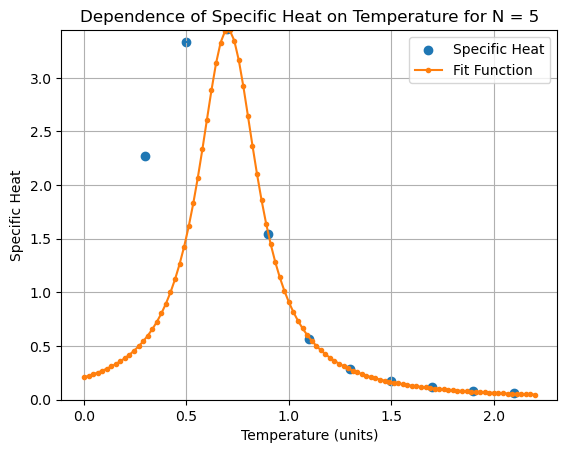

Acceptance rate 0.12610666666666667
Acceptance rate 0.15857333333333334
Acceptance rate 0.20647333333333334
Acceptance rate 0.2989266666666667
Acceptance rate 0.4482933333333333
Acceptance rate 0.74708
Acceptance rate 0.6791733333333333
Acceptance rate 0.11474
Acceptance rate 0.0013
Acceptance rate 0.0003
Acceptance rate 0.00026
Fitting for N = 8


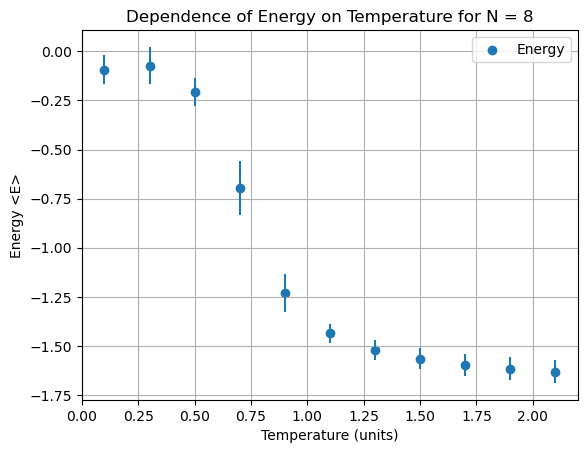

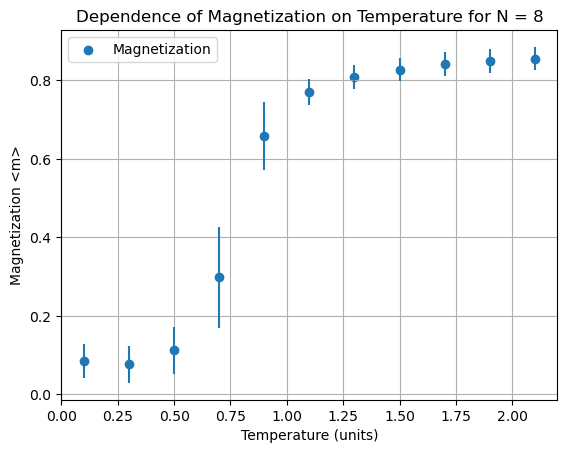

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 11
    # variables        = 3
    chi-square         = 1.35891265
    reduced chi-square = 0.16986408
    Akaike info crit   = -17.0033146
    Bayesian info crit = -15.8096288
    R-squared          = 0.58035385
[[Variables]]
    amp1:  1.65169810 +/- 0.41962472 (25.41%) (init = 0.25)
    cen1:  0.72290124 +/- 0.06513916 (9.01%) (init = 0.6)
    wid1:  0.21303081 +/- 0.07732332 (36.30%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.653
    C(cen1, wid1) = -0.179
    C(amp1, cen1) = 0.164


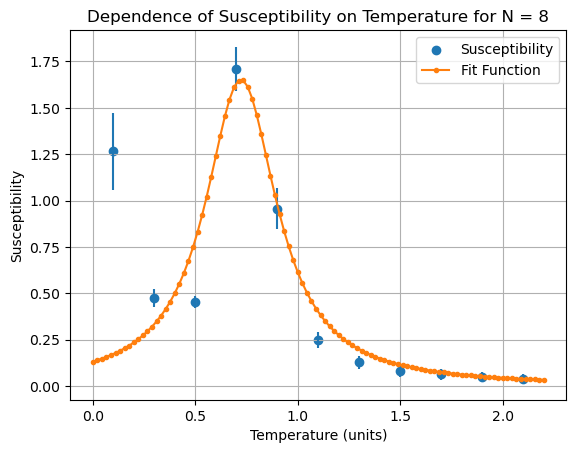

[3.01188616 0.75044454 0.1829018 ]


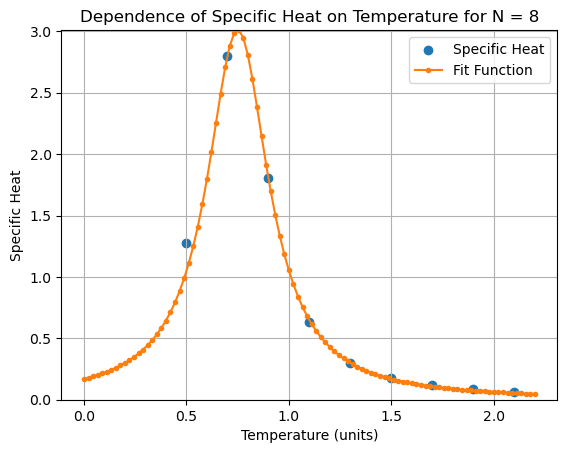

Acceptance rate 0.05699333333333333
Acceptance rate 0.08596666666666666
Acceptance rate 0.11969333333333333
Acceptance rate 0.19328666666666666
Acceptance rate 0.35161333333333333
Acceptance rate 0.69702
Acceptance rate 0.6144333333333334
Acceptance rate 0.05454666666666667
Acceptance rate 0.0003733333333333333
Acceptance rate 0.0003066666666666667
Acceptance rate 0.0002666666666666667
Fitting for N = 10


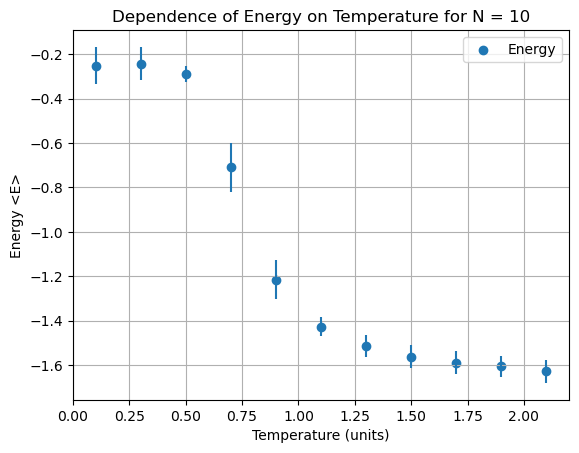

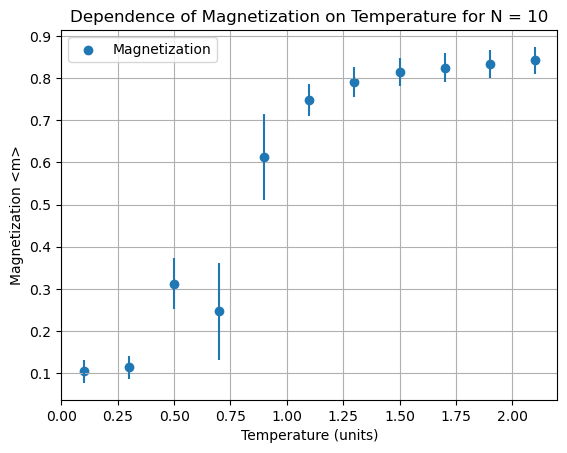

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 11
    # variables        = 3
    chi-square         = 0.42996651
    reduced chi-square = 0.05374581
    Akaike info crit   = -29.6613756
    Bayesian info crit = -28.4676898
    R-squared          = 0.90554723
[[Variables]]
    amp1:  2.36636770 +/- 0.35850830 (15.15%) (init = 0.25)
    cen1:  0.77384200 +/- 0.02015733 (2.60%) (init = 0.6)
    wid1:  0.18179737 +/- 0.03899495 (21.45%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.832
    C(amp1, cen1) = 0.340
    C(cen1, wid1) = -0.336


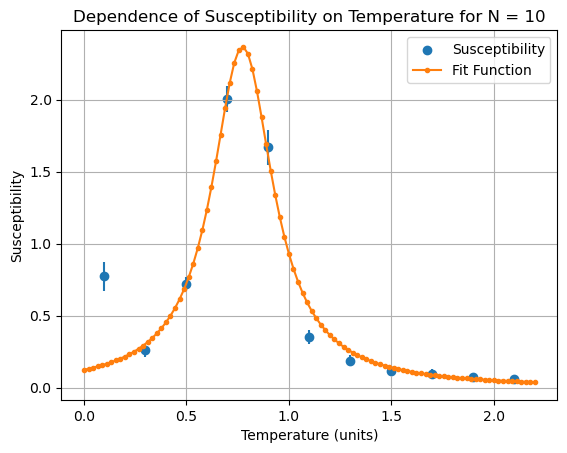

[2.98735326 0.77102609 0.17737216]


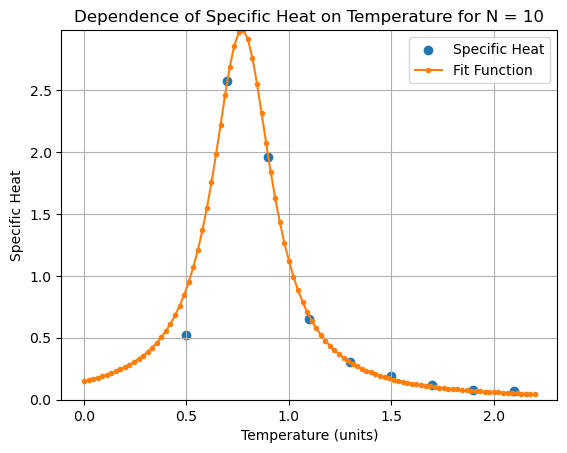

Acceptance rate 0.026193333333333332
Acceptance rate 0.03798
Acceptance rate 0.06600666666666667
Acceptance rate 0.12647333333333333
Acceptance rate 0.26386
Acceptance rate 0.6473466666666666
Acceptance rate 0.5582733333333333
Acceptance rate 0.03032
Acceptance rate 0.00036666666666666667
Acceptance rate 0.00024
Acceptance rate 0.00036
Fitting for N = 12


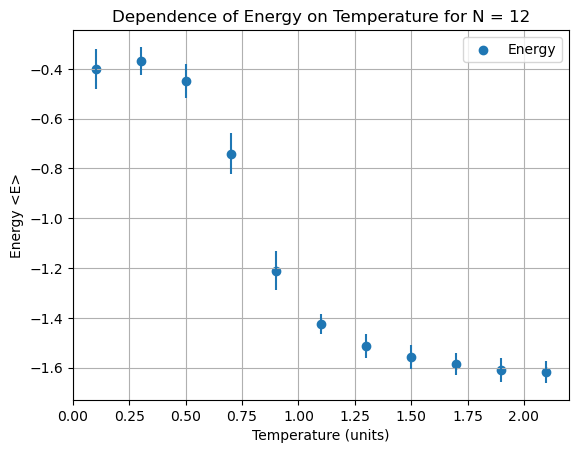

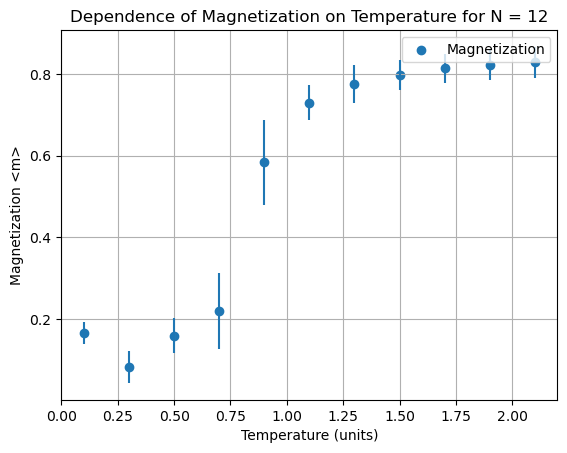

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 11
    # variables        = 3
    chi-square         = 1.14706247
    reduced chi-square = 0.14338281
    Akaike info crit   = -18.8676007
    Bayesian info crit = -17.6739149
    R-squared          = 0.78689270
[[Variables]]
    amp1:  2.56692240 +/- 0.55046545 (21.44%) (init = 0.25)
    cen1:  0.81346504 +/- 0.02951798 (3.63%) (init = 0.6)
    wid1:  0.19477976 +/- 0.05985132 (30.73%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.824
    C(amp1, cen1) = -0.158
    C(cen1, wid1) = 0.157


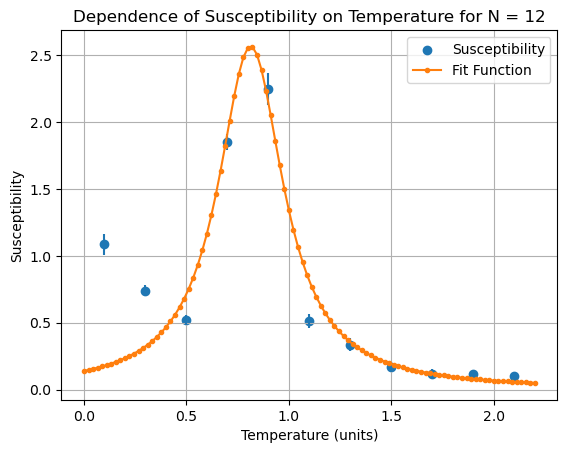

[2.5712087  0.79630792 0.18750928]


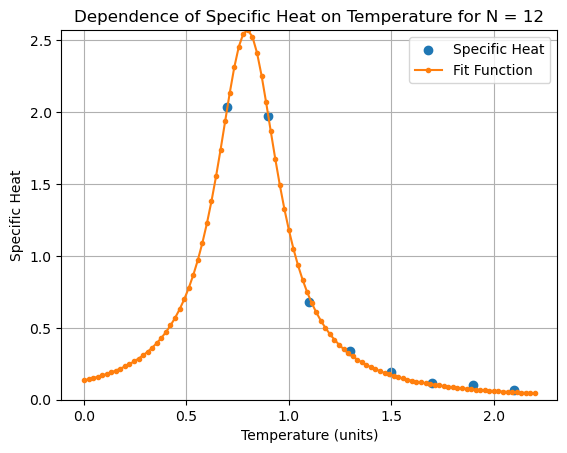

Acceptance rate 0.007866666666666666
Acceptance rate 0.01178
Acceptance rate 0.02856
Acceptance rate 0.05918
Acceptance rate 0.17257333333333333
Acceptance rate 0.5783066666666666
Acceptance rate 0.4809
Acceptance rate 0.00764
Acceptance rate 0.00038666666666666667
Acceptance rate 0.00026


C:\Users\arsal\AppData\Local\Temp\ipykernel_4980\4092246456.py:18: RuntimeWarning: overflow encountered in exp
  prob = np.exp(Hamiltonian2D_art(J,L_i,p_hmc,beta)-Hamiltonian2D_art(J,new[1],new[0],beta))


Acceptance rate 0.0002466666666666667
Fitting for N = 15


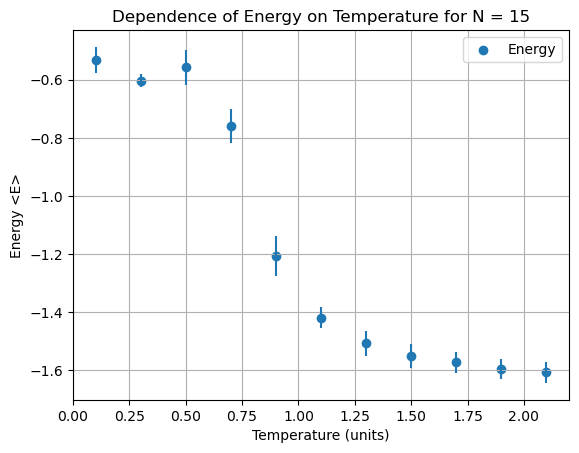

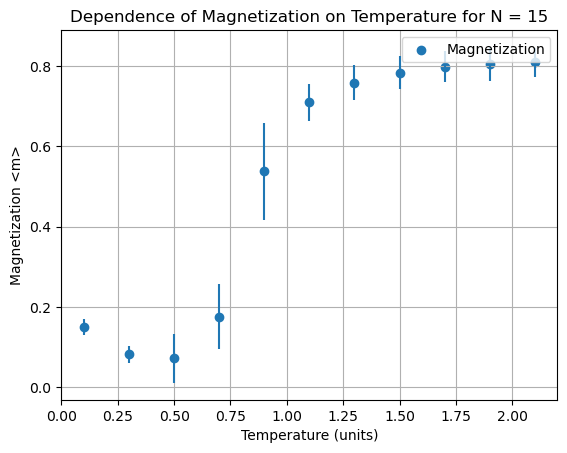

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 11
    # variables        = 3
    chi-square         = 1.74640598
    reduced chi-square = 0.21830075
    Akaike info crit   = -14.2436885
    Bayesian info crit = -13.0500027
    R-squared          = 0.88356125
[[Variables]]
    amp1:  4.57372489 +/- 0.85224173 (18.63%) (init = 0.25)
    cen1:  0.84370918 +/- 0.02423750 (2.87%) (init = 0.6)
    wid1:  0.15236311 +/- 0.03847229 (25.25%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.847
    C(amp1, cen1) = -0.619
    C(cen1, wid1) = 0.577


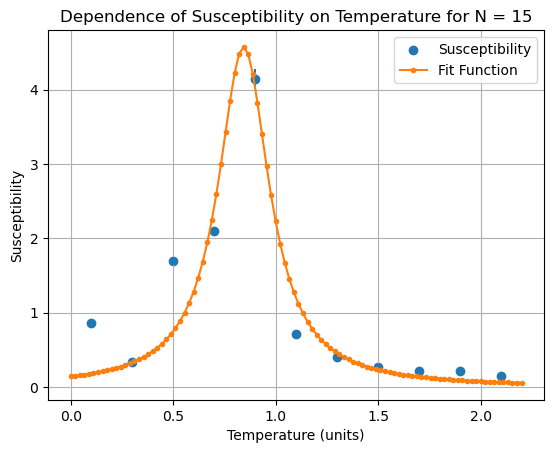

[2.49282535 0.82432998 0.17576124]


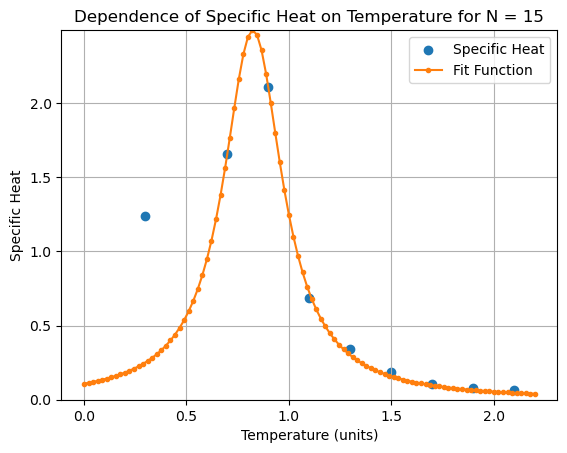

In [16]:
"""Now we will calculate the fittings for spin lattices of different sizes"""
# Analysis_func(N,n_therm,bin_length,N_cfg,N_md,J,T_arr,beta_arr)
# Fittings(T_arr, N, E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std)

N_list = [5,8,10,12,15]

# n_therm = 10 # for test run
# N_cfg = 5 # for test run

n_therm = 10000
N_cfg = 5000

bin_length = 30
N_md = 50


J = 1.0
T_arr = np.arange(0.1, 2.20, 0.20)
beta_arr=np.sort(1/T_arr)

E_means_new = []
E_std_new = []
mag_means_new = []
m_std_new = []
sus_new = []
sus_std_new = []
heat_new = []
heat_std_new = []

for N in N_list:
    L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)]) #generating a random lattice of the size N

    E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std  = Analysis_func(N,n_therm,bin_length,N_cfg,N_md,J,T_arr,beta_arr,L_i)

    E_means_new.append(E_means)
    E_std_new.append(E_std)
    mag_means_new.append(mag_means)
    m_std_new.append(m_std)
    sus_new.append(sus)
    sus_std_new.append(sus_std)
    heat_new.append(heat)
    heat_std_new.append(heat_std)
    
    print(f"Fitting for N = {N}")
    Fittings(T_arr, N, E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std)


Considering the peak to be somewhere around 0.83, T = 1/0.83 = 1.204 in natural units where k_B = 1

But here the graph is not completely correct as we see that there is a secondary peak at the same y-axis level.

# TRENDS

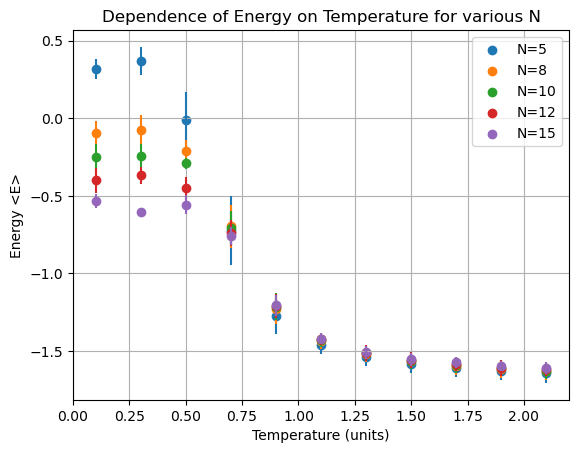

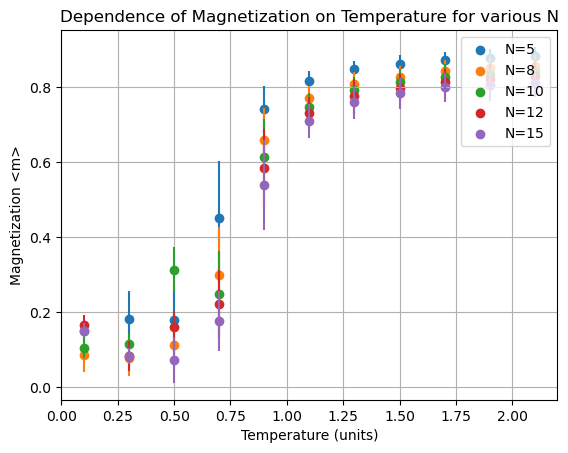

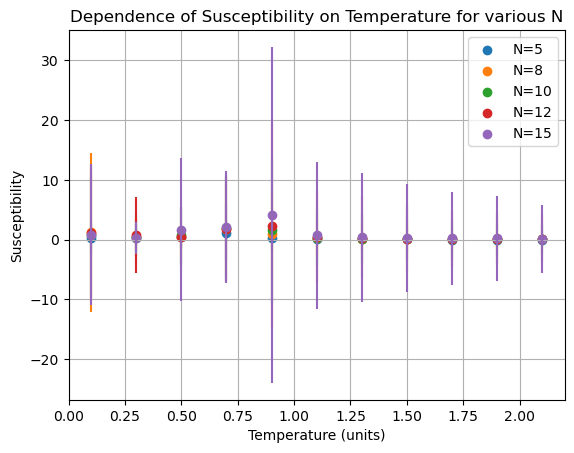

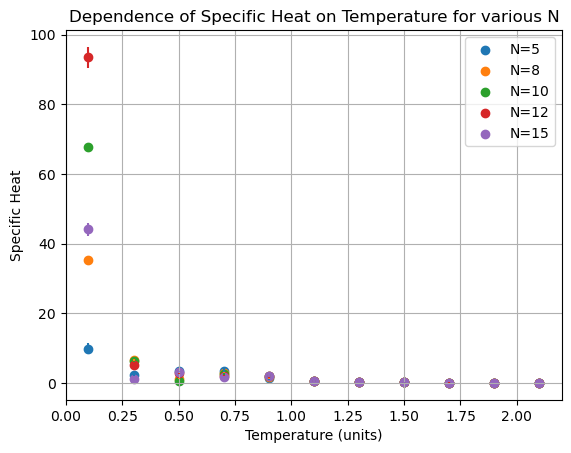

In [17]:
Trends(N_list,E_means_new,E_std_new,mag_means_new,m_std_new,sus_new,sus_std_new,heat_new,heat_std_new)